In [1]:
%matplotlib widget

import sys
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import OrderedDict
import scipy.stats

from tqdm.notebook import tqdm

In [2]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}

# Using LaTeX in figures
plt.rc('text', usetex=True)
plt.rc('font',**font)

# Intersecting fracture in RGPS and MOSAiC Sentinel-1 deformation data

## Read data

In [3]:
data = {'MOSAiC' : np.load('intersection_angle_data_mosaic.npz'),
        'RGPS'   : np.load('intersection_angle_data_rgps.npz')}

## Generate Mask

In [4]:
life_thres = 1
len_thres = 0
atype = 0

mask = OrderedDict()
masks = [OrderedDict() for i in range(3)]
types = ['All','Conjugate', 'Non-conjugate']

for ikey in data.keys():
    mask[ikey] = np.all([np.all(data[ikey]['lifetimes']<=life_thres,axis=1),
                         np.all(data[ikey]['lengths']>=len_thres,axis=1),
                         data[ikey]['type']==atype],axis=0)
    
    masks[1][ikey] = np.all([np.all(data[ikey]['lifetimes']<=life_thres,axis=1),
                         np.all(data[ikey]['lengths']>=len_thres,axis=1),
                         data[ikey]['type']==0],axis=0)
    masks[2][ikey] = np.all([np.all(data[ikey]['lifetimes']<=life_thres,axis=1),
                         np.all(data[ikey]['lengths']>=len_thres,axis=1),
                         data[ikey]['type']==1],axis=0)
    masks[0][ikey] = np.all([np.all(data[ikey]['lifetimes']<=life_thres,axis=1),
                         np.all(data[ikey]['lengths']>=len_thres,axis=1)],axis=0)

## Plot Results

Intersection angle PDF

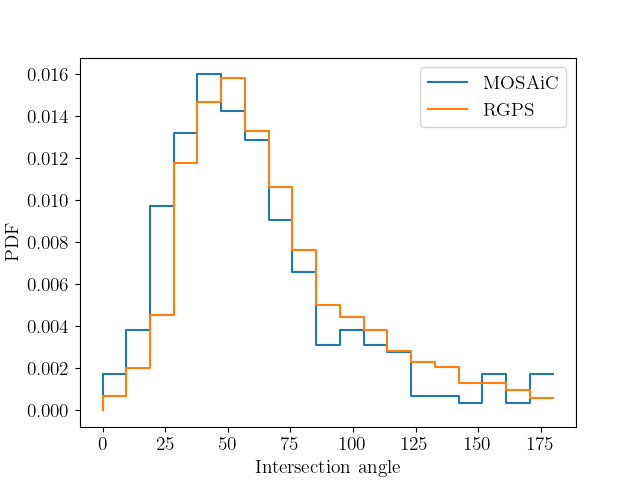

In [5]:
fig,ax = plt.subplots(1,1)

ax.set_xlabel('Intersection angle')
ax.set_ylabel('PDF')

bins = np.linspace(0,180,20)

for ikey in data.keys():
    pdf,bins = np.histogram(data[ikey]['angle'][mask[ikey]],bins=bins,density=True)
    #ax.plot(0.5*(bins[1:]+bins[:-1]),pdf,label=ikey)
    ax.step(bins,np.concatenate([np.array([0]),pdf]),label=ikey)
    
ax.legend()

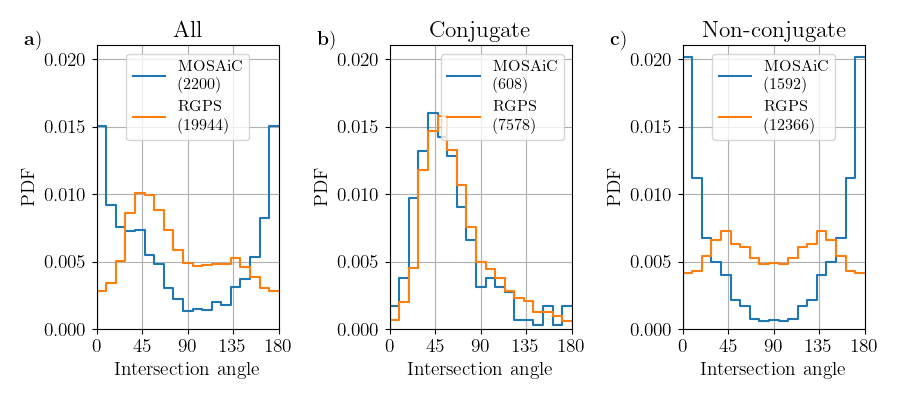

In [6]:
fig,ax = plt.subplots(1,3,tight_layout=True,figsize=(9,4))

for i in range(3):
    ax[i].set_xlabel('Intersection angle')
    ax[i].set_ylabel('PDF')
    ax[i].set_title(types[i])
    ax[i].set_xticks([0,45,90,135,180])
    ax[i].set_xlim([0,180])
    ax[i].set_ylim([0,0.021])
    
    bins = np.linspace(0,180,20)

    for ikey in data.keys():
        pdf,bins = np.histogram(data[ikey]['angle'][masks[i][ikey]],bins=bins,density=True)
        #ax.plot(0.5*(bins[1:]+bins[:-1]),pdf,label=ikey)
        ax[i].step(bins,np.concatenate([np.array([0]),pdf]),label='%s\n(%i)' %(ikey,np.sum(masks[i][ikey])))

    #ax[i].legend()
    
for i,iax in enumerate(ax.flatten()):
    iax.legend(fontsize='small')
    iax.grid()
    ylims = iax.get_ylim()
    iax.set_ylim([0,ylims[1]])
    iax.text(-0.4*np.diff(iax.get_xlim())+iax.get_xlim()[0],ylims[1],["$\\bf{a)}$","$\\bf{b)}$","$\\bf{c)}$","$\\bf{d)}$"][i])
    
fig.savefig('all_angles.pdf')

In [7]:
data[ikey].files

['angle', 'type', 'lifetimes', 'lengths', 'shears', 'divergences', 'dates']

Intersection angle PDF seasonal variability

/Users/dringeis/miniconda/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


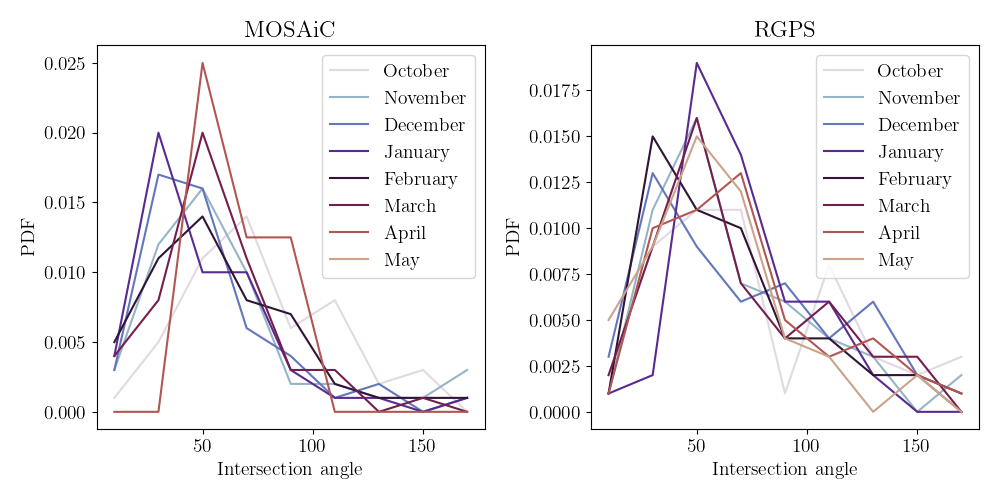

In [8]:
fig,ax = plt.subplots(1,2,tight_layout=True,figsize=(10,5))

for iax in ax:
    iax.set_xlabel('Intersection angle')
    iax.set_ylabel('PDF')

bins = np.linspace(0,180,10)

months  = ['October','November','December','January','February','March','April','May']

for ip, ikey in enumerate(data.keys()):
    for i,im in enumerate([10,11,12,1,2,3,4,5]):
        maskm = data[ikey]['dates'][mask[ikey]].astype('datetime64[M]').astype(int)%12+1==im
        pdf,bins = np.histogram(data[ikey]['angle'][mask[ikey]][i*100:(i+1)*100],bins=bins,density=True)
        ax[ip].plot(0.5*(bins[1:]+bins[:-1]),pdf,label=months[i],color=plt.get_cmap('twilight')(i/8))
        #ax.step(bins,np.concatenate([np.array([0]),pdf]),label=ikey)
    ax[ip].set_title(ikey)
    
for iax in ax: iax.legend()

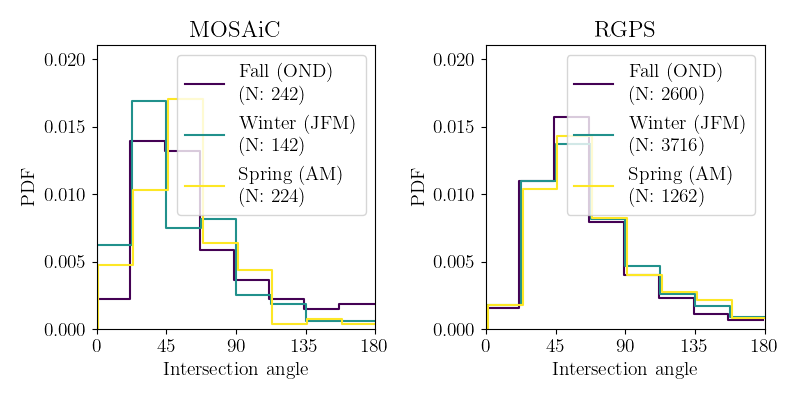

In [9]:
fig,ax = plt.subplots(1,2,tight_layout=True,figsize=(8,4))

for iax in ax:
    iax.set_xlabel('Intersection angle')
    iax.set_ylabel('PDF')

bins = np.linspace(0,180,9)

seasons  = ['Fall (OND)','Winter (JFM)','Spring (AM)']

for ip, ikey in enumerate(data.keys()):
    for i,im in enumerate([[10,11,12],[1,2,3],[4,5]]):
        maskm = np.any([data[ikey]['dates'][mask[ikey]].astype('datetime64[M]').astype(int)%12+1==imi for imi in im],axis=0)
        pdf,bins = np.histogram(data[ikey]['angle'][mask[ikey]][maskm],bins=bins,density=True)#[i*100:(i+1)*100],bins=bins,density=True)
        #ax[ip].plot(0.5*(bins[1:]+bins[:-1]),pdf,label=seasons[i]+'\n(N: %i)' %np.sum(maskm),color=plt.get_cmap('viridis')(i/2),
        #            marker='.')
        ax[ip].step(bins+(i-1),np.concatenate([np.array([0]),pdf]),label=seasons[i]+'\n(N: %i)' %np.sum(maskm),color=plt.get_cmap('viridis')(i/2))
    ax[ip].set_title(ikey)
    

    
for iax in ax: 
    iax.legend()
    iax.set_xticks([0,45,90,135,180])
    iax.set_xlim([0,180])
    iax.set_ylim([0,0.021])

Deformation rates along LKFs

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


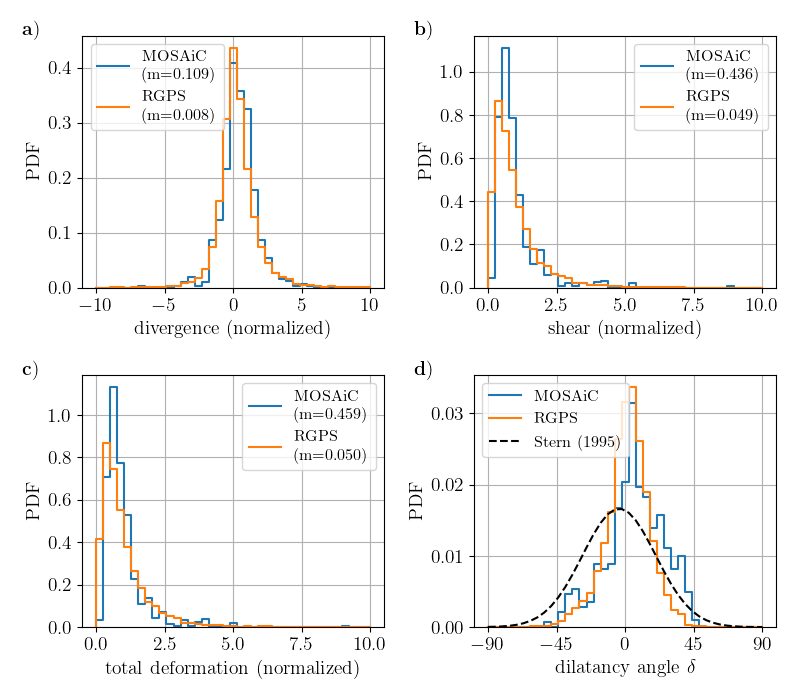

In [25]:
fig,ax = plt.subplots(2,2,tight_layout=True,figsize=(8,7))

for iax in ax.flatten():
    iax.set_ylabel('PDF')
    
ax[0,0].set_xlabel('divergence (normalized)')
for ikey in data.keys():
    datamean = np.nanmean(np.abs(data[ikey]['divergences'][mask[ikey],:]))
    pdf,bins = np.histogram(data[ikey]['divergences'][mask[ikey],:].flatten()/datamean,bins=np.linspace(-10,10,40),density=True)#(-0.3,0.3,40))
    ax[0,0].step(bins,np.concatenate([np.array([0]),pdf]),label='%s\n(m=%.03f)' %(ikey,datamean)) #/np.sum(mask[ikey])
    print(np.sum(pdf*np.diff(bins)))
ax[0,0].legend(fontsize='small')

ax[0,1].set_xlabel('shear (normalized)')
for ikey in data.keys():
    datamean = np.nanmean(data[ikey]['shears'][mask[ikey],:])
    pdf,bins = np.histogram(data[ikey]['shears'][mask[ikey],:].flatten()/datamean,bins=np.linspace(0.0,10,40),density=True)#(0.0,1.0,40))
    ax[0,1].step(bins,np.concatenate([np.array([0]),pdf]),label='%s\n(m=%.03f)' %(ikey,datamean)) #/np.sum(mask[ikey])
    print(np.sum(pdf*np.diff(bins)))
ax[0,1].legend(fontsize='small')#prop={'size': 6, 'fontsize': 'small'})

ax[1,0].set_xlabel('total deformation (normalized)')
for ikey in data.keys():
    datamean = np.nanmean(np.sqrt(data[ikey]['shears'][mask[ikey],:].flatten()**2+
                                  data[ikey]['divergences'][mask[ikey],:].flatten()**2))
    pdf,bins = np.histogram((np.sqrt(data[ikey]['shears'][mask[ikey],:].flatten()**2+
                                    data[ikey]['divergences'][mask[ikey],:].flatten()**2)/
                             datamean),
                            bins=np.linspace(0.0,10,40),density=True)#1.0
    ax[1,0].step(bins,np.concatenate([np.array([0]),pdf]),label='%s\n(m=%.03f)' %(ikey,datamean)) # /np.sum(mask[ikey])
    print(np.sum(pdf*np.diff(bins)))
ax[1,0].legend(fontsize='small')
    
ax[1,1].set_xlabel(r'dilatancy angle $\delta$')
for ikey in data.keys():
    # datamean = np.nanmean(np.arctan2(data[ikey]['divergences'][mask[ikey],:].flatten(),
                                     # data[ikey]['shears'][mask[ikey],:].flatten())/np.pi*180)
    pdf,bins = np.histogram(np.arctan2(data[ikey]['divergences'][mask[ikey],:].flatten(),
                                       data[ikey]['shears'][mask[ikey],:].flatten())/np.pi*180,
                            bins=np.linspace(-90,90,40),density=True)
    # ax[1,1].step(bins,np.concatenate([np.array([0]),pdf]),label='%s\n(m %.01f)' %(ikey,datamean)) # /np.sum(mask[ikey])
    ax[1,1].step(bins,np.concatenate([np.array([0]),pdf]),label='%s' %(ikey)) # /np.sum(mask[ikey])
    ax[1,1].set_xticks([-90,-45,0,45,90])
    print(np.sum(pdf*np.diff(bins)))
    
mu,sig = -(94-90),24
ax[1,1].plot(bins,1/np.sqrt(2*np.pi*sig**2)*np.exp(-(bins-mu)**2/2/sig**2),'k--',label='Stern (1995)')

for i,iax in enumerate(ax.flatten()):
    iax.legend(fontsize='small',loc=0)
    iax.grid()
    ylims = iax.get_ylim()
    iax.set_ylim([0,ylims[1]])
    iax.text(-0.2*np.diff(iax.get_xlim())+iax.get_xlim()[0],ylims[1],["$\\bf{a)}$","$\\bf{b)}$","$\\bf{c)}$","$\\bf{d)}$"][i])
    
fig.savefig('deformation_rates_along_lkfs.pdf',dpi=300)

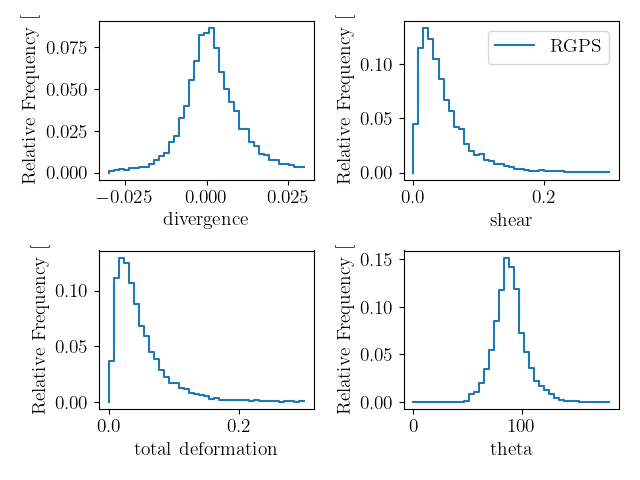

In [11]:
fig,ax = plt.subplots(2,2,tight_layout=True)

for iax in ax.flatten():
    iax.set_ylabel('Relative Frequency [%]')
    
ax[0,0].set_xlabel('divergence')
for ikey in ['RGPS']:
    pdf,bins = np.histogram(data[ikey]['divergences'][mask[ikey],:].flatten(),bins=np.linspace(-0.03,0.03,40))
    ax[0,0].step(bins,np.concatenate([np.array([0]),pdf])/2/np.sum(mask[ikey]),label=ikey)

ax[0,1].set_xlabel('shear')
for ikey in ['RGPS']:
    pdf,bins = np.histogram(data[ikey]['shears'][mask[ikey],:].flatten(),bins=np.linspace(0.0,0.3,40))
    ax[0,1].step(bins,np.concatenate([np.array([0]),pdf])/2/np.sum(mask[ikey]),label=ikey)
ax[0,1].legend()

ax[1,0].set_xlabel('total deformation')
for ikey in ['RGPS']:
    pdf,bins = np.histogram(np.sqrt(data[ikey]['shears'][mask[ikey],:].flatten()**2+
                                    data[ikey]['divergences'][mask[ikey],:].flatten()**2),
                            bins=np.linspace(0.0,0.3,40))
    ax[1,0].step(bins,np.concatenate([np.array([0]),pdf])/2/np.sum(mask[ikey]),label=ikey)

ax[1,1].set_xlabel('theta')
for ikey in ['RGPS']:
    pdf,bins = np.histogram(np.arctan2(data[ikey]['shears'][mask[ikey],:].flatten(),
                                       data[ikey]['divergences'][mask[ikey],:].flatten())/np.pi*180,
                            bins=np.linspace(0,180,40))
    ax[1,1].step(bins,np.concatenate([np.array([0]),pdf])/2/np.sum(mask[ikey]),label=ikey)


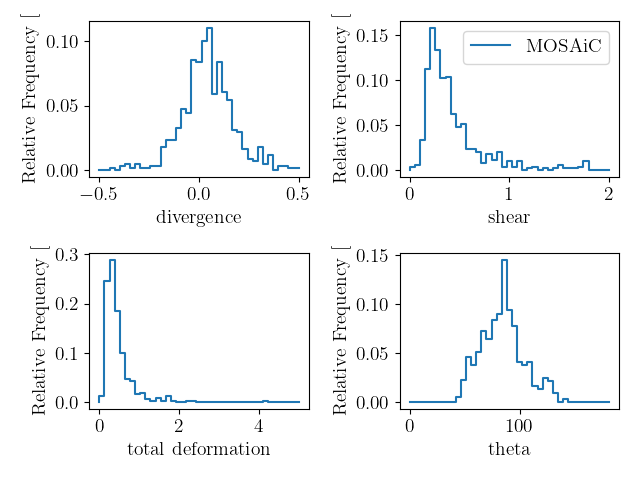

In [12]:
fig,ax = plt.subplots(2,2,tight_layout=True)

for iax in ax.flatten():
    iax.set_ylabel('Relative Frequency [%]')
    
ax[0,0].set_xlabel('divergence')
for ikey in ['MOSAiC']:
    pdf,bins = np.histogram(data[ikey]['divergences'][mask[ikey],:].flatten(),bins=np.linspace(-0.5,0.5,40))
    ax[0,0].step(bins,np.concatenate([np.array([0]),pdf])/2/np.sum(mask[ikey]),label=ikey)

ax[0,1].set_xlabel('shear')
for ikey in ['MOSAiC']:
    pdf,bins = np.histogram(data[ikey]['shears'][mask[ikey],:].flatten(),bins=np.linspace(0.0,2.0,40))
    ax[0,1].step(bins,np.concatenate([np.array([0]),pdf])/2/np.sum(mask[ikey]),label=ikey)
ax[0,1].legend()

ax[1,0].set_xlabel('total deformation')
for ikey in ['MOSAiC']:
    pdf,bins = np.histogram(np.sqrt(data[ikey]['shears'][mask[ikey],:].flatten()**2+
                                    data[ikey]['divergences'][mask[ikey],:].flatten()**2),
                            bins=np.linspace(0.0,5.0,40))
    ax[1,0].step(bins,np.concatenate([np.array([0]),pdf])/2/np.sum(mask[ikey]),label=ikey)

ax[1,1].set_xlabel('theta')
for ikey in ['MOSAiC']:
    pdf,bins = np.histogram(np.arctan2(data[ikey]['shears'][mask[ikey],:].flatten(),
                                       data[ikey]['divergences'][mask[ikey],:].flatten())/np.pi*180,
                            bins=np.linspace(0,180,40))
    ax[1,1].step(bins,np.concatenate([np.array([0]),pdf])/2/np.sum(mask[ikey]),label=ikey)


Relationship between intersection angles and deformation rates

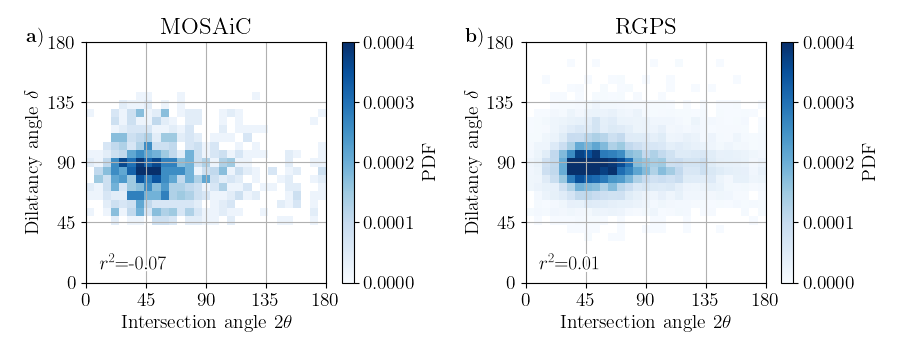

In [13]:
import matplotlib.patheffects as path_effects

fig,ax = plt.subplots(1,2,tight_layout=True,figsize=(9,3.5))

for iax in ax:
    iax.set_xlabel(r'Intersection angle  $2\theta$')
    #iax.set_ylim([-0.25,0.25])
    iax.set_ylabel(r'Dilatancy angle $\delta$')
    
for i,ikey in enumerate(data.keys()):
    ax[i].set_title(ikey)
    pdf, bins_d, bins_i = np.histogram2d(np.arctan2(data[ikey]['shears'][mask[ikey],:].flatten(),
                                                    data[ikey]['divergences'][mask[ikey],:].flatten())/np.pi*180,
                                         np.concatenate([data[ikey]['angle'][mask[ikey]],data[ikey]['angle'][mask[ikey]]]),
                                         [np.linspace(0,180,30),np.linspace(0,180,30)],density=True)
    pcm = ax[i].pcolormesh(bins_i,bins_d,np.ma.masked_where(pdf==0,pdf),cmap='Blues',vmin=0,vmax=4e-4)
    #ax[i].scatter(np.concatenate([data[ikey]['angle'][mask[ikey]],data[ikey]['angle'][mask[ikey]]]),
    #              np.arctan2(data[ikey]['shears'][mask[ikey],:].flatten(),
    #                                   data[ikey]['divergences'][mask[ikey],:].flatten())/np.pi*180,alpha=0.05)
    

    ang = np.concatenate([data[ikey]['angle'][mask[ikey]],data[ikey]['angle'][mask[ikey]]])
    theta = np.arctan2(data[ikey]['shears'][mask[ikey],:].flatten(),
                                           data[ikey]['divergences'][mask[ikey],:].flatten())/np.pi*180
    masknan = np.all([~np.isnan(ang),~np.isnan(theta)],axis=0)

    text = ax[i].text(10,10,'$r^2$=%.02f' %scipy.stats.pearsonr(ang[masknan],theta[masknan])[0])
    text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'),path_effects.Normal()])
    
    ax[i].set_xticks([0,45,90,135,180])
    ax[i].set_yticks([0,45,90,135,180])
    
    #add_colorbar(pcm,label='PDF')
    cbar = plt.colorbar(pcm,label='PDF',ax=ax[i])
    iax=ax[i]
    iax.text(-0.25*np.diff(iax.get_xlim())+iax.get_xlim()[0],iax.get_ylim()[1],["$\\bf{a)}$","$\\bf{b)}$","$\\bf{c)}$","$\\bf{d)}$"][i])
    iax.grid()
    iax.set_aspect('equal')
    
#     pdf,xedges,yedges = np.histogram2d(np.concatenate([data[ikey]['angle'][mask[ikey]],data[ikey]['angle'][mask[ikey]]]),
#                                        data[ikey]['divergences'][mask[ikey],:].flatten(),
#                                        bins = [np.linspace(0,180,40),np.linspace(-0.25,0.25,40)],
#                                        density=True)
#     ax[i].pcolormesh(xedges,yedges,pdf)

fig.savefig('delta_vs_intersection_angle')

PearsonRResult(statistic=-0.5025906426326944, pvalue=3.1208642605040866e-40)
ConfidenceInterval(low=-0.5597370558602449, high=-0.4406865152434842)
PearsonRResult(statistic=0.4552637171418979, pvalue=2.4374569096657632e-32)
ConfidenceInterval(low=0.38974930766903815, high=0.5161932297978726)
PearsonRResult(statistic=-0.19345006947863358, pvalue=8.470232110480541e-65)
ConfidenceInterval(low=-0.215029071504451, high=-0.17168226424349176)
PearsonRResult(statistic=0.19638289732577646, pvalue=1.0415007875379369e-66)
ConfidenceInterval(low=0.17463085326237526, high=0.21794335163771605)


/var/folders/jk/nc7lpbb10jldxr36nlplkpz80000gn/T/ipykernel_35409/2952418185.py:24: RuntimeWarning: invalid value encountered in arccos
  ang_acos=np.arccos(ang_tan)/np.pi*180
/var/folders/jk/nc7lpbb10jldxr36nlplkpz80000gn/T/ipykernel_35409/2952418185.py:24: RuntimeWarning: invalid value encountered in arccos
  ang_acos=np.arccos(ang_tan)/np.pi*180


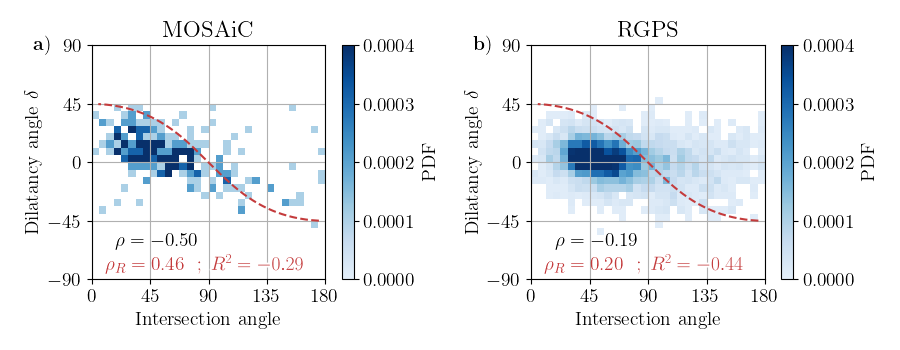

In [14]:
import matplotlib.patheffects as path_effects
import matplotlib.colors as colors
from sklearn.metrics import r2_score

def r_squared(y, y_hat):
    y_bar = y.mean()
    # print('y_bar')
    ss_tot = ((y-y_bar)**2).sum()
    # print(ss_tot)
    ss_res = ((y-y_hat)**2).sum()
    # print(ss_res)
    return 1 - (ss_res/ss_tot)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def theo_theta(ang):
    # print(ang[:10])
    ang_tan=np.tan(ang/180*np.pi)
    # print(ang_tan[0:10])
    ang_acos=np.arccos(ang_tan)/np.pi*180
    # print(ang_acos[0:10])
    return ang_acos

fig,ax = plt.subplots(1,2,tight_layout=True,figsize=(9,3.5))
for iax in ax:
    iax.set_xlabel('Intersection angle')
    iax.set_ylabel(r'Dilatancy angle $\delta$')
    #iax.set_ylim([-0.25,0.25])
for i,ikey in enumerate(data.keys()):
    ax[i].set_title(ikey)
    pdf, bins_d, bins_i = np.histogram2d(np.nanmean(np.arctan2(data[ikey]['divergences'][mask[ikey],:],
                                                    data[ikey]['shears'][mask[ikey],:])/np.pi*180,axis=1),
                                         data[ikey]['angle'][mask[ikey]],
                                         [np.linspace(-90,90,33),np.linspace(0,180,33)],density=True)
    pcm = ax[i].pcolormesh(bins_i,bins_d,np.ma.masked_where(pdf==0,pdf),cmap=truncate_colormap(plt.get_cmap('Blues'),0.1,1.0),vmin=0,vmax=4e-4)
    #ax[i].scatter(np.concatenate([data[ikey]['angle'][mask[ikey]],data[ikey]['angle'][mask[ikey]]]),
    #              np.arctan2(data[ikey]['shears'][mask[ikey],:].flatten(),
    #                                   data[ikey]['divergences'][mask[ikey],:].flatten())/np.pi*180,alpha=0.05)
    
    ang = data[ikey]['angle'][mask[ikey]]
    theta = np.nanmean(np.arctan2(data[ikey]['divergences'][mask[ikey],:],
                                  data[ikey]['shears'][mask[ikey],:])/np.pi*180,axis=1)
    masknan = np.all([~np.isnan(ang),~np.isnan(theta)],axis=0)
    
    # poly = np.polyfit(ang[masknan],theta[masknan],1)
    
    # ax[i].plot(np.linspace(0,180,20),np.polyval(poly,np.linspace(0,180,20)),'k--')
    
    # with scipy
    pr=scipy.stats.pearsonr(ang[masknan],theta[masknan])
    c=pr[0]
    p=pr[1]
    if p < 0.001:
        pt = r'$p < 0.001$'
    print(pr)
    print(pr.confidence_interval())
    
    # with numpy
    # pr=np.corrcoef(ang[masknan],theta[masknan])
    # p=pr[0,1]

    lsp=np.linspace(-90,90,400)
    delta_RNFR = theo_theta(lsp)
    
    tn=theta[masknan]
    mask45=np.abs(tn)<45
    tnr=tn[mask45]
    
    tt=theo_theta(tnr)
    # print(theta[masknan])
    # print(tt[:10])
    
    # r2 = r_squared(theta[masknan][mask45],tt)
    # r2 = r2_score(theta[masknan][mask45], tt) 
    rho = scipy.stats.pearsonr(ang[masknan][mask45],tt) 
    print(rho)
    print(rho.confidence_interval())
    r2 = r2_score(ang[masknan][mask45],tt) 
    ax[i].plot(delta_RNFR,lsp,'--',color=plt.get_cmap('RdBu')(0.15))
    # ax[i].plot(tt,theta[masknan][mask45],'.',color=plt.get_cmap('RdBu')(0.25))
    # ax[i].plot(ang[masknan][mask45],theta[masknan][mask45],'.',color=plt.get_cmap('RdBu')(0.35))
    text = ax[i].text(0.1,0.14,r'$\rho=%.2f$' %(c),transform=ax[i].transAxes) # with scipy
    text = ax[i].text(0.055,0.04,r'$\rho_R=%.2f$' %(rho[0]),transform=ax[i].transAxes,c=plt.get_cmap('RdBu')(0.15)) # with scipy
    text = ax[i].text(0.45,0.04,r'$~;~R^2=%.2f$' %(r2),transform=ax[i].transAxes,c=plt.get_cmap('RdBu')(0.15)) # with scipy
    # text = ax[i].text(0.1,0.1,r'$\rho=%.2f$' %(p),transform=ax[i].transAxes) # with numpy
    text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'),path_effects.Normal()])

    ax[i].set_xticks([0,45,90,135,180])
    ax[i].set_yticks([-90,-45,0,45,90])
    
    #add_colorbar(pcm,label='PDF')
    cbar = plt.colorbar(pcm,label='PDF',ax=ax[i])
    iax=ax[i]
    iax.text(-0.25,1.0,["$\\bf{a)}$","$\\bf{b)}$","$\\bf{c)}$","$\\bf{d)}$"][i],transform=ax[i].transAxes,va='center')
    iax.grid()
    iax.set_aspect('equal')
    
#     pdf,xedges,yedges = np.histogram2d(np.concatenate([data[ikey]['angle'][mask[ikey]],data[ikey]['angle'][mask[ikey]]]),
#                                        data[ikey]['divergences'][mask[ikey],:].flatten(),
#                                        bins = [np.linspace(0,180,40),np.linspace(-0.25,0.25,40)],
#                                        density=True)
#     ax[i].pcolormesh(xedges,yedges,pdf)

    fig.savefig('delta_vs_intersection_angle_new.pdf', dpi=600)

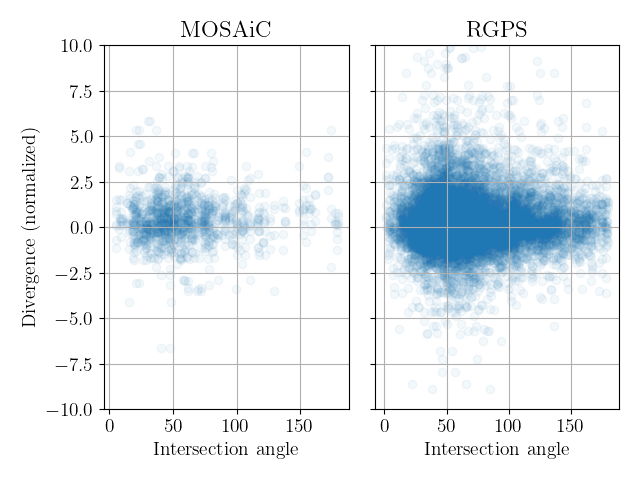

In [15]:
fig,ax = plt.subplots(1,2,tight_layout=True, sharey=True)

for iax in ax:
    iax.set_xlabel('Intersection angle')
    iax.set_ylim([-10,10])
    iax.grid()

ax[0].set_ylabel('Divergence (normalized)')

    
for i,ikey in enumerate(data.keys()):
    ax[i].set_title(ikey)
    datamean = np.nanmean(np.abs(data[ikey]['divergences'][mask[ikey],:]))
    ax[i].scatter(np.concatenate([data[ikey]['angle'][mask[ikey]],data[ikey]['angle'][mask[ikey]]]),
                  data[ikey]['divergences'][mask[ikey],:].flatten()/datamean,alpha=0.05)
    
    
#     pdf,xedges,yedges = np.histogram2d(np.concatenate([data[ikey]['angle'][mask[ikey]],data[ikey]['angle'][mask[ikey]]]),
#                                        data[ikey]['divergences'][mask[ikey],:].flatten(),
#                                        bins = [np.linspace(0,180,40),np.linspace(-0.25,0.25,40)],
#                                        density=True)
#     ax[i].pcolormesh(xedges,yedges,pdf)

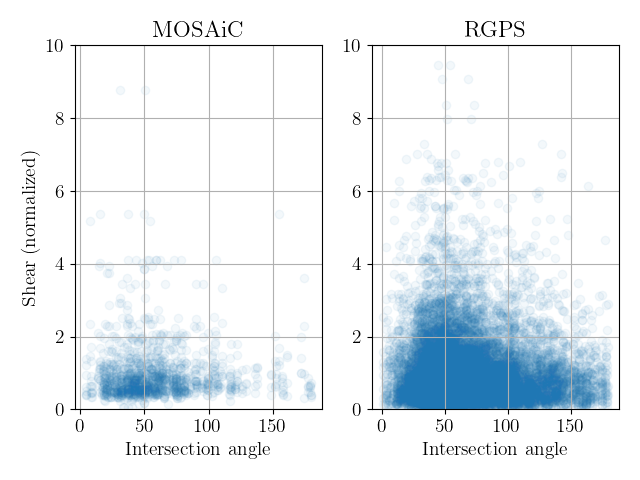

In [16]:
fig,ax = plt.subplots(1,2,tight_layout=True)

for iax in ax:
    iax.set_xlabel('Intersection angle')
    #iax.set_ylabel('Shear (normalized)')
    iax.set_ylim([0,10])
    iax.grid()

ax[0].set_ylabel('Shear (normalized)')
    

for i,ikey in enumerate(data.keys()):
    ax[i].set_title(ikey)
    datamean = np.nanmean(np.abs(data[ikey]['shears'][mask[ikey],:]))
    ax[i].scatter(np.concatenate([data[ikey]['angle'][mask[ikey]],data[ikey]['angle'][mask[ikey]]]),
                  data[ikey]['shears'][mask[ikey],:].flatten()/datamean,alpha=0.05)
    
    
#     pdf,xedges,yedges = np.histogram2d(np.concatenate([data[ikey]['angle'][mask[ikey]],data[ikey]['angle'][mask[ikey]]]),
#                                        data[ikey]['divergences'][mask[ikey],:].flatten(),
#                                        bins = [np.linspace(0,180,40),np.linspace(-0.25,0.25,40)],
#                                        density=True)
#     ax[i].pcolormesh(xedges,yedges,pdf)